Processed class 1 (original folder 11): 1377 cells
Processed class 3 (original folder 8): 1383 cells

At distance 0.0: U=405170.00, p=9.59×10^-84
At distance 0.7: U=209834.00, p=2.82×10^-275


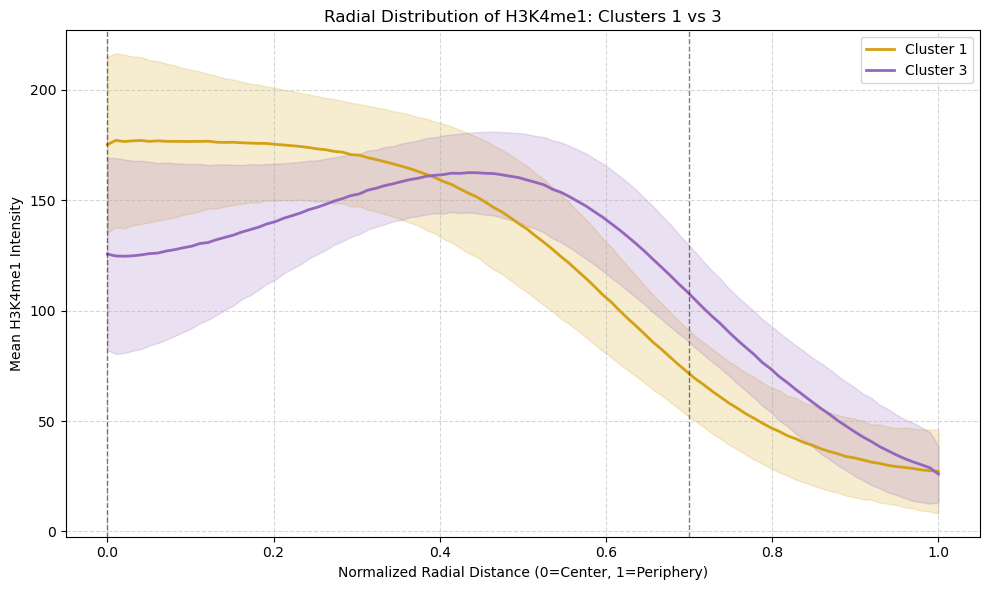

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.stats import mannwhitneyu
import seaborn as sns

root_dir = r"QUAC_cortex_types/H3K4me1/train"

# --- Compute radial distributions ---
radial_profiles = {}

# Only process folders 11 and 8, correspond to class 1 and 3
folders_to_process = ['11', '8']
folder_rename = {'11': '1', '8': '3'}

for subfolder in folders_to_process:
    class_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(class_path):
        continue
    
    renamed_folder = folder_rename[subfolder]
    radial_profiles[renamed_folder] = []
    
    for filename in os.listdir(class_path):
        if not filename.lower().endswith(".tiff"):
            continue
        img_path = os.path.join(class_path, filename)
        img = io.imread(img_path).astype(float)
        
        nonzero_mask = img > 0
        if not np.any(nonzero_mask):
            continue
        
        # Get coordinates of all non-zero pixels
        y_coords_nonzero, x_coords_nonzero = np.where(nonzero_mask)
        
        # Calculate geometric center (mean of coordinates)
        center_y = np.mean(y_coords_nonzero)
        center_x = np.mean(x_coords_nonzero)
        
        # Create coordinate grids
        y_coords, x_coords = np.ogrid[:img.shape[0], :img.shape[1]]
        
        # Calculate distance from geometric center for each pixel
        distances = np.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
        
        # Normalize distances to 0-1 (0=center, 1=max distance)
        max_dist = distances[nonzero_mask].max()
        if max_dist > 0:
            normalized_dist = distances / max_dist
        else:
            continue
        
        # Calculate average intensity at each normalized distance
        # Use 100 bins from 0 (center) to 1 (periphery)
        bins = np.linspace(0, 1, 101)
        profile = []
        
        for i in range(len(bins)-1):
            mask_ring = (normalized_dist >= bins[i]) & (normalized_dist < bins[i+1]) & nonzero_mask
            if np.any(mask_ring):
                mean_intensity = np.mean(img[mask_ring])
                profile.append(mean_intensity)
            else:
                profile.append(np.nan)
        
        radial_profiles[renamed_folder].append(profile)
    
    print(f"Processed class {renamed_folder} (original folder {subfolder}): {len(radial_profiles[renamed_folder])} cells")

# --- Calculate p-values between class 1 and 3 at distance 0 and 0.7 ---
radial_positions = np.linspace(0, 1, 100)

# Find indices closest to distance 0 and 0.7
idx_0 = np.argmin(np.abs(radial_positions - 0))
idx_07 = np.argmin(np.abs(radial_positions - 0.7))

if '1' in radial_profiles and '3' in radial_profiles:
    profiles_1 = np.array(radial_profiles['1'])
    profiles_3 = np.array(radial_profiles['3'])
    
    # Extract intensities at distance 0
    intensities_1_at_0 = profiles_1[:, idx_0]
    intensities_3_at_0 = profiles_3[:, idx_0]
    
    # Extract intensities at distance 0.7
    intensities_1_at_07 = profiles_1[:, idx_07]
    intensities_3_at_07 = profiles_3[:, idx_07]
    
    # Remove NaN values
    intensities_1_at_0 = intensities_1_at_0[~np.isnan(intensities_1_at_0)]
    intensities_3_at_0 = intensities_3_at_0[~np.isnan(intensities_3_at_0)]
    intensities_1_at_07 = intensities_1_at_07[~np.isnan(intensities_1_at_07)]
    intensities_3_at_07 = intensities_3_at_07[~np.isnan(intensities_3_at_07)]
    
    # Mann-Whitney U test
    if len(intensities_1_at_0) > 0 and len(intensities_3_at_0) > 0:
        stat_0, p_0 = mannwhitneyu(intensities_1_at_0, intensities_3_at_0, alternative='two-sided')
        if p_0 > 0:
            exponent_0 = int(np.floor(np.log10(p_0)))
            mantissa_0 = p_0 / (10 ** exponent_0)
            print(f"\nAt distance 0.0: U={stat_0:.2f}, p={mantissa_0:.2f}×10^{exponent_0}")
        else:
            print(f"\nAt distance 0.0: U={stat_0:.2f}, p<10^-308")
    
    if len(intensities_1_at_07) > 0 and len(intensities_3_at_07) > 0:
        stat_07, p_07 = mannwhitneyu(intensities_1_at_07, intensities_3_at_07, alternative='two-sided')
        if p_07 > 0:
            exponent_07 = int(np.floor(np.log10(p_07)))
            mantissa_07 = p_07 / (10 ** exponent_07)
            print(f"At distance 0.7: U={stat_07:.2f}, p={mantissa_07:.2f}×10^{exponent_07}")
        else:
            print(f"At distance 0.7: U={stat_07:.2f}, p<10^-308")

# --- Plot mean radial profiles with standard deviation (Classes 1 and 3) ---
plt.figure(figsize=(10,6))
colors_dict = {'1': '#d4a017', '3': '#9467bd'}
cluster_order = ['1', '3']

for cls in cluster_order:
    if cls not in radial_profiles or len(radial_profiles[cls]) == 0:
        continue
    
    # Convert to array and compute mean and std
    profiles_array = np.array(radial_profiles[cls])
    mean_profile = np.nanmean(profiles_array, axis=0)
    std_profile = np.nanstd(profiles_array, axis=0)
    
    # Plot mean with shaded standard deviation
    plt.plot(radial_positions, mean_profile, color=colors_dict[cls], 
             label=f'Cluster {cls}', linewidth=2)
    plt.fill_between(radial_positions, 
                     mean_profile - std_profile, 
                     mean_profile + std_profile, 
                     color=colors_dict[cls], alpha=0.2)

# Add dashed vertical lines at distance 0 and 0.7
plt.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(0.7, color='black', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel("Normalized Radial Distance (0=Center, 1=Periphery)")
plt.ylabel("Mean H3K4me1 Intensity")
plt.title("Radial Distribution of H3K4me1: Clusters 1 vs 3")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig("./cortex_curves/H3K4me1_radial_distribution_clusters_1_3.pdf", dpi=300)
plt.show()

Processed class 0 (original folder 11): 1377 cells
Processed class 3 (original folder 8): 1383 cells

At distance 0.0: U=386560.50, p=1.41×10^-68
At distance 0.7: U=277910.00, p=1.95×10^-227


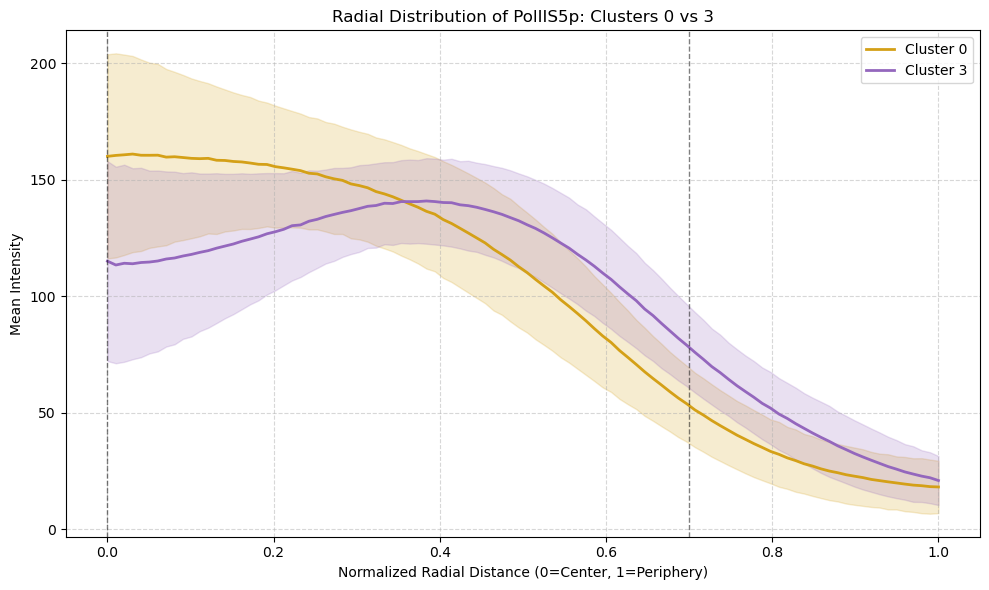

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.stats import mannwhitneyu
import seaborn as sns

root_dir = r"QUAC_cortex_types/PolIIS5p/train"

# --- Compute radial distributions ---
radial_profiles = {}

# Only process folders 11 and 8, correspond to class 1 and 3
folders_to_process = ['11', '8']
folder_rename = {'11': '0', '8': '3'}

for subfolder in folders_to_process:
    class_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(class_path):
        continue
    
    renamed_folder = folder_rename[subfolder]
    radial_profiles[renamed_folder] = []
    
    for filename in os.listdir(class_path):
        if not filename.lower().endswith(".tiff"):
            continue
        img_path = os.path.join(class_path, filename)
        img = io.imread(img_path).astype(float)
        
        nonzero_mask = img > 0
        if not np.any(nonzero_mask):
            continue
        
        # Get coordinates of all non-zero pixels
        y_coords_nonzero, x_coords_nonzero = np.where(nonzero_mask)
        
        # Calculate geometric center (mean of coordinates)
        center_y = np.mean(y_coords_nonzero)
        center_x = np.mean(x_coords_nonzero)
        
        # Create coordinate grids
        y_coords, x_coords = np.ogrid[:img.shape[0], :img.shape[1]]
        
        # Calculate distance from geometric center for each pixel
        distances = np.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
        
        # Normalize distances to 0-1 (0=center, 1=max distance)
        max_dist = distances[nonzero_mask].max()
        if max_dist > 0:
            normalized_dist = distances / max_dist
        else:
            continue
        
        # Calculate average intensity at each normalized distance
        # Use 100 bins from 0 (center) to 1 (periphery)
        bins = np.linspace(0, 1, 101)
        profile = []
        
        for i in range(len(bins)-1):
            mask_ring = (normalized_dist >= bins[i]) & (normalized_dist < bins[i+1]) & nonzero_mask
            if np.any(mask_ring):
                mean_intensity = np.mean(img[mask_ring])
                profile.append(mean_intensity)
            else:
                profile.append(np.nan)
        
        radial_profiles[renamed_folder].append(profile)
    
    print(f"Processed class {renamed_folder} (original folder {subfolder}): {len(radial_profiles[renamed_folder])} cells")

# --- Calculate p-values between class 0 and 3 at distance 0 and 0.7 ---
radial_positions = np.linspace(0, 1, 100)

# Find indices closest to distance 0 and 0.7
idx_0 = np.argmin(np.abs(radial_positions - 0))
idx_07 = np.argmin(np.abs(radial_positions - 0.7))

if '0' in radial_profiles and '3' in radial_profiles:
    profiles_0 = np.array(radial_profiles['0'])
    profiles_3 = np.array(radial_profiles['3'])
    
    # Extract intensities at distance 0
    intensities_0_at_0 = profiles_0[:, idx_0]
    intensities_3_at_0 = profiles_3[:, idx_0]
    
    # Extract intensities at distance 0.7
    intensities_0_at_07 = profiles_0[:, idx_07]
    intensities_3_at_07 = profiles_3[:, idx_07]
    
    # Remove NaN values
    intensities_0_at_0 = intensities_0_at_0[~np.isnan(intensities_0_at_0)]
    intensities_3_at_0 = intensities_3_at_0[~np.isnan(intensities_3_at_0)]
    intensities_0_at_07 = intensities_0_at_07[~np.isnan(intensities_0_at_07)]
    intensities_3_at_07 = intensities_3_at_07[~np.isnan(intensities_3_at_07)]
    
    # Mann-Whitney U test
    if len(intensities_0_at_0) > 0 and len(intensities_3_at_0) > 0:
        stat_0, p_0 = mannwhitneyu(intensities_0_at_0, intensities_3_at_0, alternative='two-sided')
        if p_0 > 0:
            exponent_0 = int(np.floor(np.log10(p_0)))
            mantissa_0 = p_0 / (10 ** exponent_0)
            print(f"\nAt distance 0.0: U={stat_0:.2f}, p={mantissa_0:.2f}×10^{exponent_0}")
        else:
            print(f"\nAt distance 0.0: U={stat_0:.2f}, p<10^-308")
    
    if len(intensities_0_at_07) > 0 and len(intensities_3_at_07) > 0:
        stat_07, p_07 = mannwhitneyu(intensities_0_at_07, intensities_3_at_07, alternative='two-sided')
        if p_07 > 0:
            exponent_07 = int(np.floor(np.log10(p_07)))
            mantissa_07 = p_07 / (10 ** exponent_07)
            print(f"At distance 0.7: U={stat_07:.2f}, p={mantissa_07:.2f}×10^{exponent_07}")
        else:
            print(f"At distance 0.7: U={stat_07:.2f}, p<10^-308")

# --- Plot mean radial profiles with standard deviation (Classes 0 and 3) ---
plt.figure(figsize=(10,6))
colors_dict = {'0': '#d4a017', '3': '#9467bd'}
cluster_order = ['0', '3']

for cls in cluster_order:
    if cls not in radial_profiles or len(radial_profiles[cls]) == 0:
        continue
    
    # Convert to array and compute mean and std
    profiles_array = np.array(radial_profiles[cls])
    mean_profile = np.nanmean(profiles_array, axis=0)
    std_profile = np.nanstd(profiles_array, axis=0)
    
    # Plot mean with shaded standard deviation
    plt.plot(radial_positions, mean_profile, color=colors_dict[cls], 
             label=f'Cluster {cls}', linewidth=2)
    plt.fill_between(radial_positions, 
                     mean_profile - std_profile, 
                     mean_profile + std_profile, 
                     color=colors_dict[cls], alpha=0.2)

# Add dashed vertical lines at distance 0 and 0.7
plt.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(0.7, color='black', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel("Normalized Radial Distance (0=Center, 1=Periphery)")
plt.ylabel("Mean Intensity")
plt.title("Radial Distribution of PolIIS5p: Clusters 0 vs 3")
plt.legend()

ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_ticks = np.arange(0, y_max, 50)
ax.set_yticks(y_ticks)

plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig("./cortex_curves/PolIIS5p_radial_distribution_clusters_0_3.pdf", dpi=600)
plt.show()